In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import statsmodels.formula.api as smf 
from pandas.plotting import lag_plot
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product

In [2]:
# Loading Dataset
data = pd.read_excel(r'C:\Users\Sooraj\Downloads\CocaCola_Sales_Rawdata.xlsx')

In [3]:
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [4]:
data.shape

(42, 2)

In [5]:
data['Quarters'] = 0
data['Year'] = 0
for i in range(42):
    p = data["Quarter"][i]
    data.loc[i, 'Quarters'] = p[0:2]
    data.loc[i, 'Year'] = p[3:5]

In [6]:
data.head()

,Quarter,Sales,Quarters,Year
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87


In [7]:
# Getting dummy variables for Quarters Q1, Q2, Q3, Q4 
data = pd.concat([data, pd.get_dummies(data['Quarters'])], axis=1)
data.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


In [8]:
# Convert two-digit year to four-digit year
data['Year'] = pd.to_numeric(data['Year']) + 1900
data['Year'] = np.where(data['Year'] < 1950, data['Year'] + 100, data['Year'])

# Display the updated DataFrame
data.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,1986,1,0,0,0
1,Q2_86,2244.960999,Q2,1986,0,1,0,0
2,Q3_86,2533.804993,Q3,1986,0,0,1,0
3,Q4_86,2154.962997,Q4,1986,0,0,0,1
4,Q1_87,1547.818996,Q1,1987,1,0,0,0


In [9]:
# Drop unnecessary columns
data.drop(['Quarter'], axis=1, inplace=True)
data.head()

,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,1734.827000,Q1,1986,1,0,0,0
1,2244.960999,Q2,1986,0,1,0,0
2,2533.804993,Q3,1986,0,0,1,0
3,2154.962997,Q4,1986,0,0,0,1
4,1547.818996,Q1,1987,1,0,0,0


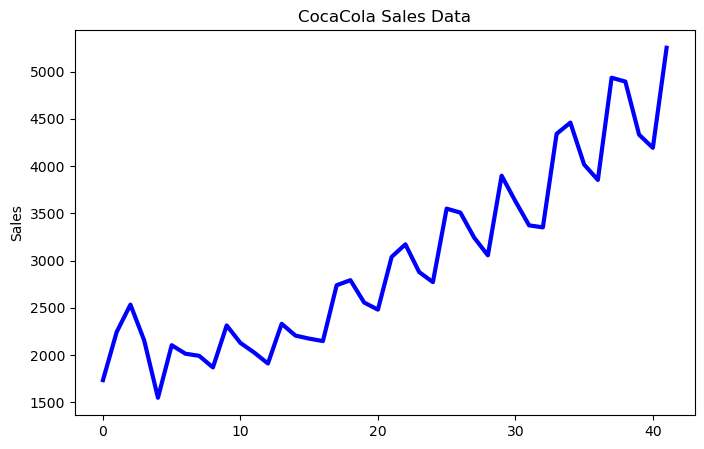

In [10]:
# Lineplot for Sales of CocaCola
plt.figure(figsize=(8,5))
plt.plot(data['Sales'], color = 'blue', linewidth=3)
plt.ylabel('Sales')
plt.title('CocaCola Sales Data')
plt.show()

<Axes: >

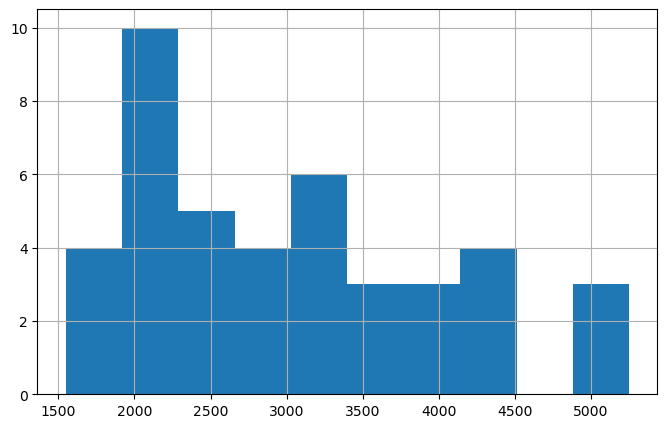

In [11]:
# Histogram
data['Sales'].hist(figsize=(8,5))

<Axes: ylabel='Density'>

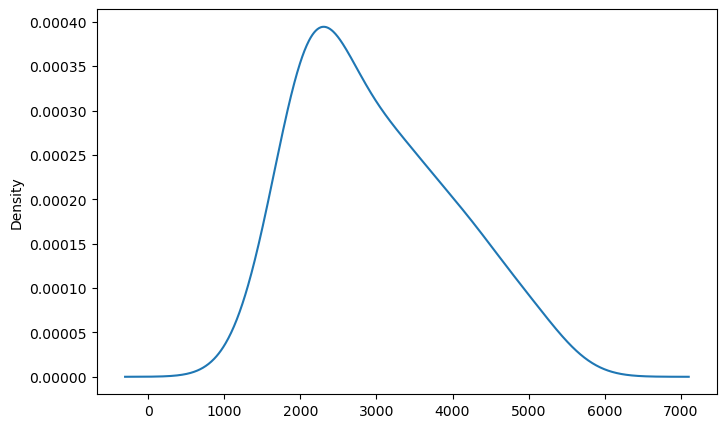

In [12]:
# Density Plot
data['Sales'].plot(kind = 'kde', figsize=(8,5))

<Axes: xlabel='Quarters', ylabel='Sales'>

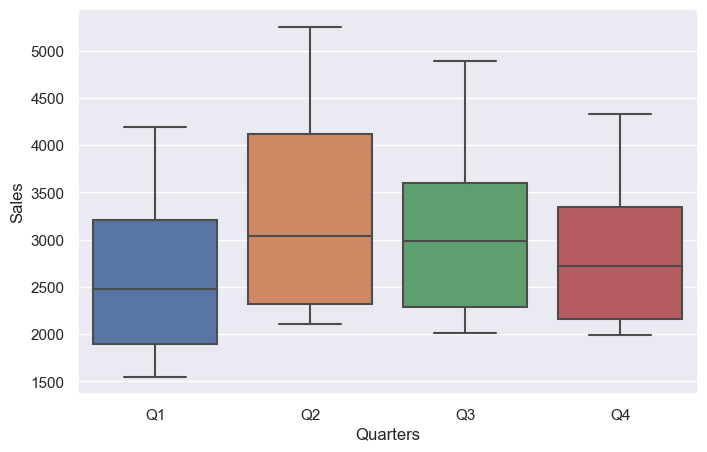

In [13]:
#boxplot of Quarters Vs. Sales
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="Quarters",y="Sales",data=data)

<Axes: xlabel='Year', ylabel='Sales'>

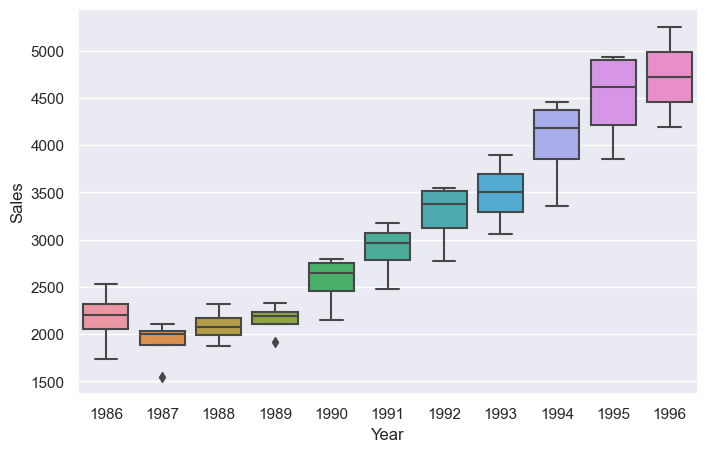

In [14]:
# boxplot of Years Vs. Sales
sns.boxplot(x="Year",y="Sales",data=data)

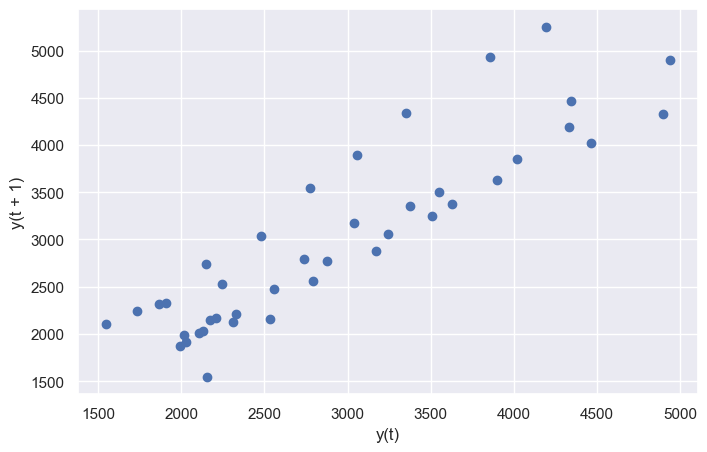

In [15]:
lag_plot(data['Sales'])
plt.show()

<Axes: xlabel='Year', ylabel='Sales'>

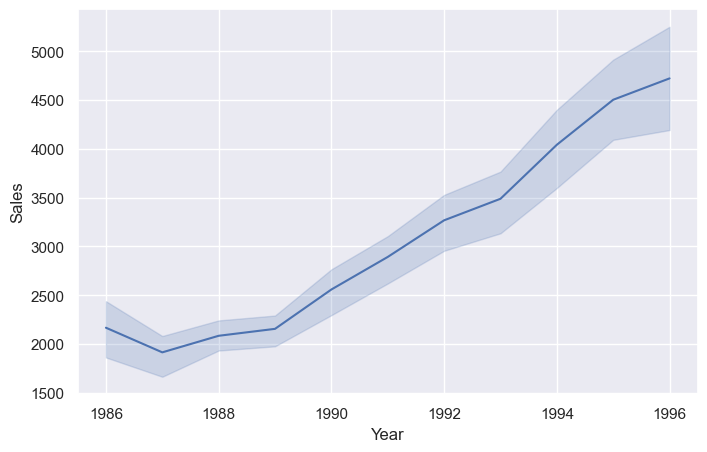

In [16]:
plt.figure(figsize=(8,5))
sns.lineplot(x="Year",y="Sales",data=data)

<Axes: xlabel='Quarters', ylabel='Year'>

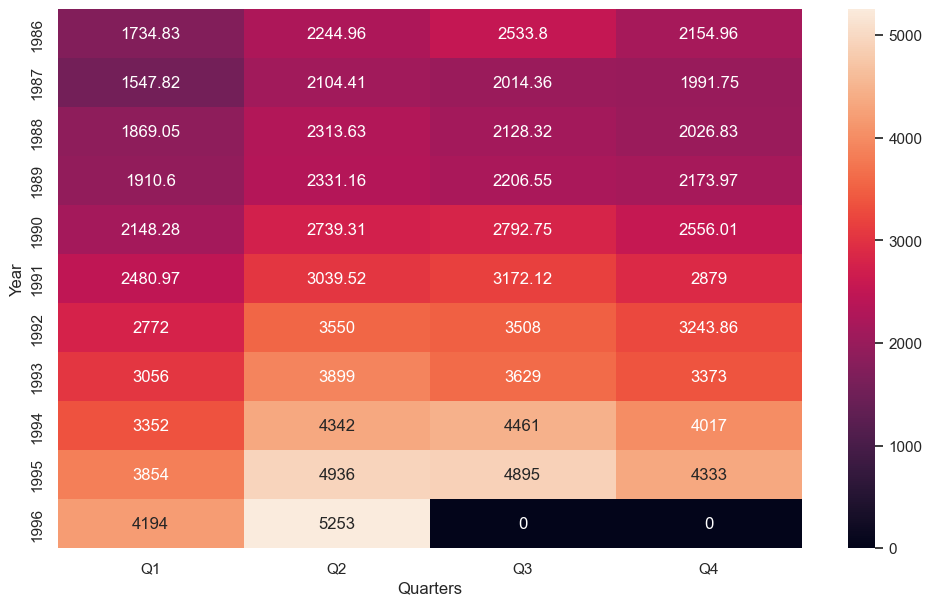

In [17]:
plt.figure(figsize=(12, 7))
heatmap_y_month = pd.pivot_table(data=data,values="Sales",index="Year",columns="Quarters",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


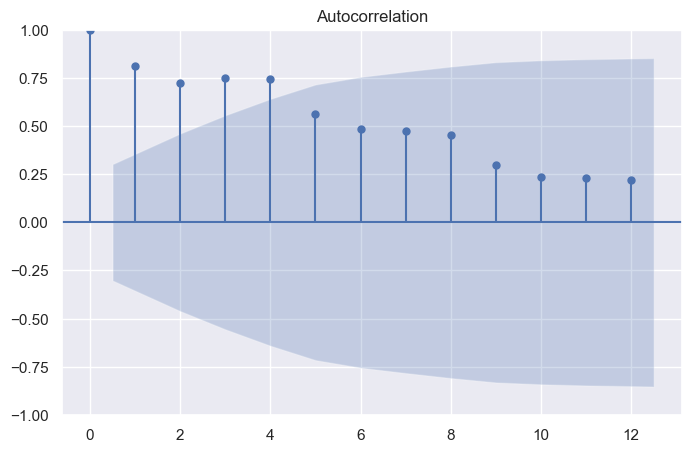

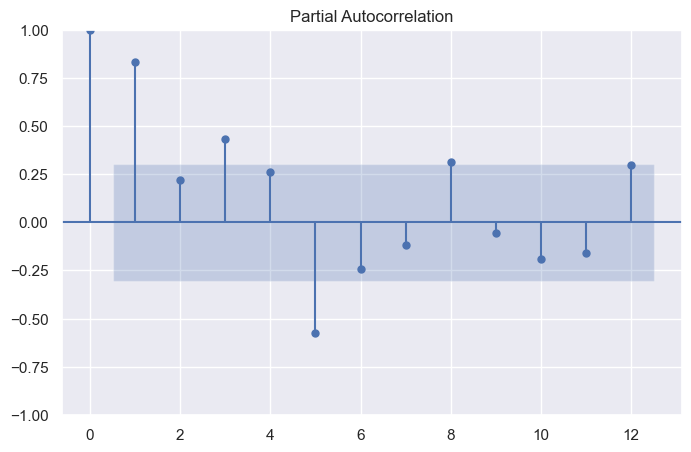

In [18]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Sales,lags=12)
tsa_plots.plot_pacf(data.Sales,lags=12)
plt.show()

# Data Driven Forecasting Methods

In [19]:
#Splitting data
train, test = train_test_split(data, test_size=0.3, shuffle=False)

## 1. Moving Average Method

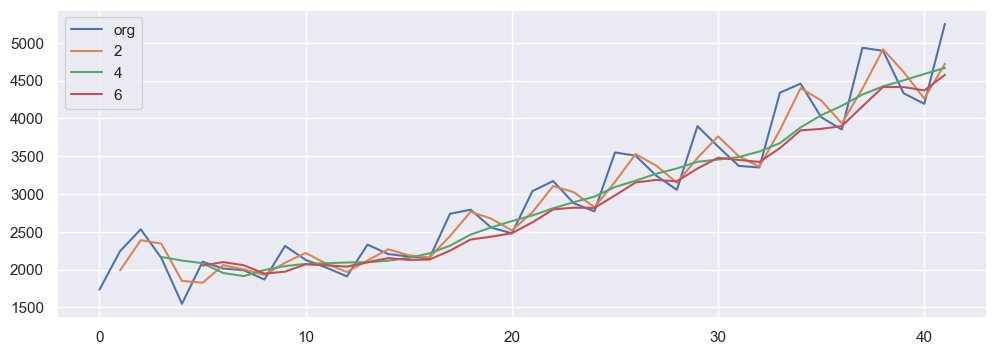

In [20]:
plt.figure(figsize=(12,4))
data.Sales.plot(label="org")
for i in range(2,8,2):
    data["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

###  Time series decomposition plot

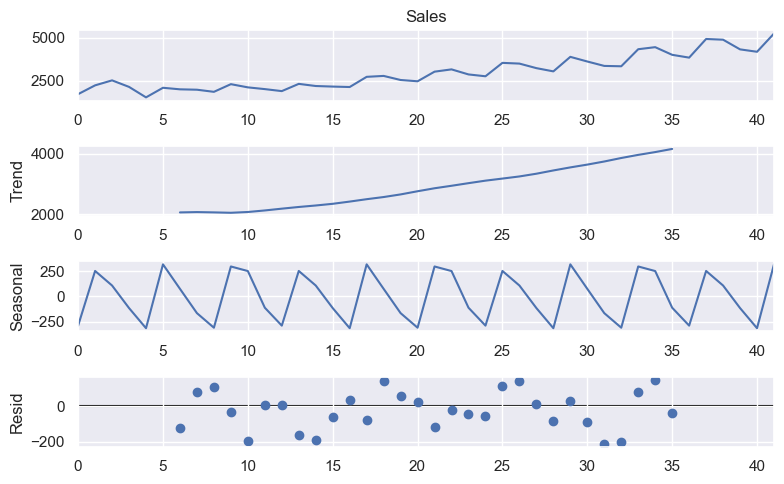

In [21]:
decompose_ts_add = seasonal_decompose(data.Sales,period=12)
decompose_ts_add.plot()
plt.show()

### Evaluation Metric RMSE

In [22]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

## 2. Simple Exponential Method

In [23]:
warnings.filterwarnings("ignore")

In [24]:
ses_model = SimpleExpSmoothing(train["Sales"]).fit()
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
rmse_ses_model = RMSE(test.Sales, pred_ses)
rmse_ses_model

1184.880804117009

## 3. Holt method

In [25]:
hw_model = Holt(train["Sales"]).fit()
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
rmse_hw_model = RMSE(test.Sales, pred_hw)
rmse_hw_model

758.157825364996

## Holts winter exponential smoothing with additive seasonality and additive trend

In [26]:
hwe_model_add_add = ExponentialSmoothing(train["Sales"],seasonal="add",trend="add",seasonal_periods=4).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
rmse_hwe_add_add_model = RMSE(test.Sales, pred_hwe_add_add)
rmse_hwe_add_add_model

538.04159099667

## Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [27]:
hwe_model_mul_add = ExponentialSmoothing(train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
rmse_hwe_model_mul_add_model = RMSE(test.Sales, pred_hwe_mul_add)
rmse_hwe_model_mul_add_model

201.60353059511

# Model based Forecasting Methods

In [28]:
# Data preprocessing for models
data["t"] = np.arange(1,43)
data["t_squared"] = data["t"]*data["t"]

data["log_sales"] = np.log(data["Sales"])

data.head()

,Sales,Quarters,Year,Q1,Q2,Q3,Q4,t,t_squared,log_sales
0,1734.827000,Q1,1986,1,0,0,0,1,1,7.458663
1,2244.960999,Q2,1986,0,1,0,0,2,4,7.716443
2,2533.804993,Q3,1986,0,0,1,0,3,9,7.837477
3,2154.962997,Q4,1986,0,0,0,1,4,16,7.675529
4,1547.818996,Q1,1987,1,0,0,0,5,25,7.344602


In [29]:
# Splitting data into Train and Test (77/33)
Train = data.head(32)
Test = data.tail(10)

## 1. Linear Model

In [30]:
linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear_model = RMSE(Test['Sales'], pred_linear)
rmse_linear_model

752.9233932767115

## 2. Exponential Model

In [31]:
Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp_model = RMSE(Test['Sales'], np.exp(pred_Exp))
rmse_Exp_model

590.3316432076576

## 3. Quadratic Model

In [32]:
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad_model = RMSE(Test['Sales'], pred_Quad)
rmse_Quad_model

457.73573554072897

## 4. Additive Seasonality model

In [33]:
add_sea = smf.ols('Sales~Q1+Q2+Q3',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1', 'Q2', 'Q3']]))
rmse_add_sea = RMSE(Test['Sales'], pred_add_sea)
rmse_add_sea

1850.4665461858353

## 5. Additive Seasonality Quadratic model

In [34]:
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1','Q2','Q3','t','t_squared']]))
rmse_add_sea_Quad_model = RMSE(Test['Sales'], pred_add_sea_quad)
rmse_add_sea_Quad_model   

277.3510771128774

## 6. Multiplicative Seasonality model

In [35]:
Mul_sea = smf.ols('log_sales~Q1+Q2+Q3',data=Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mul_sea = RMSE(Test['Sales'], np.exp(pred_Mult_sea))
rmse_Mul_sea

1908.250394836116

## 7. Multiplicative Additive Seasonality model

In [36]:
Mul_Add_sea = smf.ols('log_sales~t+Q1+Q2+Q3',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mul_Add_sea = RMSE(Test['Sales'], np.exp(pred_Mult_add_sea))
rmse_Mul_Add_sea

448.867818269187

In [37]:
list = [['Simple Exponential Method',rmse_ses_model], ['Holt method',rmse_hw_model],
          ['HW exp smoothing add',rmse_hwe_add_add_model],['HW exp smoothing mult',rmse_hwe_model_mul_add_model],
          ['Linear Mode',rmse_linear_model],['Exp model',rmse_Exp_model],['Quad model',rmse_Quad_model],
          ['add seasonality',rmse_add_sea],['Quad add seasonality',rmse_add_sea_Quad_model],
          ['Mult Seasonality',rmse_Mul_sea],['Mult add seasonality',rmse_Mul_Add_sea]]

In [38]:
df = pd.DataFrame(list, columns =['Model', 'RMSE_Value']) 
df

,Model,RMSE_Value
0,Simple Exponential Method,1184.880804
1,Holt method,758.157825
2,HW exp smoothing add,538.041591
3,HW exp smoothing mult,201.603531
4,Linear Mode,752.923393
5,Exp model,590.331643
6,Quad model,457.735736
7,add seasonality,1850.466546
8,Quad add seasonality,277.351077
9,Mult Seasonality,1908.250395


# ARIMA method

In [39]:
# Extract the 'Sales' column as a time series
ts = data['Sales']

In [40]:
# Split the data into training and testing sets
train_size = int(len(ts) * 0.7)
Train, Test = ts[:train_size], ts[train_size:]

In [41]:
# Define the range of values for p, d, q
p_values = range (3, 6)
d_values = range (3, 6)
q_values = range (3, 6)

In [42]:
# Perform grid search
best_rmse = float('inf')
best_params = None

In [43]:
for p, d, q in product(p_values, d_values, q_values):
    order = (p, d, q)
    try:
        # Fit ARIMA model
        model = ARIMA(Train, order=order)
        fit_model = model.fit()

        # Forecast
        forecast = fit_model.forecast(steps=len(Test))

        # Calculate RMSE
        rmse = sqrt(mean_squared_error(Test, forecast))

        # Update best parameters if current RMSE is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = order

        print(f'Order: {order}, RMSE: {rmse}')

    except Exception as e:
        continue

Order: (3, 3, 3), RMSE: 543.7313293733276
Order: (3, 3, 4), RMSE: 320.320054845184
Order: (3, 3, 5), RMSE: 659.0838600420736
Order: (3, 4, 3), RMSE: 765.7683105564117
Order: (3, 4, 4), RMSE: 2051.9379704389175
Order: (3, 4, 5), RMSE: 1172.1759164420184
Order: (3, 5, 3), RMSE: 2702.262539689197
Order: (3, 5, 4), RMSE: 4427.717697850198
Order: (3, 5, 5), RMSE: 3089.9947152309214
Order: (4, 3, 3), RMSE: 482.99755081056145
Order: (4, 3, 4), RMSE: 486.7286240522715
Order: (4, 3, 5), RMSE: 263.6026080881268
Order: (4, 4, 3), RMSE: 60880549.92899656
Order: (4, 4, 4), RMSE: 1151.1491914983155
Order: (4, 4, 5), RMSE: 645.4801259818914
Order: (4, 5, 3), RMSE: 2863.7574028089484
Order: (4, 5, 4), RMSE: 3177.6231679008656
Order: (4, 5, 5), RMSE: 1165.7707753914683
Order: (5, 3, 3), RMSE: 227.4544875306486
Order: (5, 3, 4), RMSE: 579.9332251691203
Order: (5, 4, 4), RMSE: 2131376.4704110883
Order: (5, 4, 5), RMSE: 352.73818528008445
Order: (5, 5, 3), RMSE: 1804.4726832051206
Order: (5, 5, 4), RMSE: 

In [44]:
print(f'Best parameters: {best_params}, Best RMSE: {best_rmse}')

Best parameters: (5, 3, 3), Best RMSE: 227.4544875306486


## Building final model with least RMSE value

In [45]:
data.head()

,Sales,Quarters,Year,Q1,Q2,Q3,Q4,t,t_squared,log_sales
0,1734.827000,Q1,1986,1,0,0,0,1,1,7.458663
1,2244.960999,Q2,1986,0,1,0,0,2,4,7.716443
2,2533.804993,Q3,1986,0,0,1,0,3,9,7.837477
3,2154.962997,Q4,1986,0,0,0,1,4,16,7.675529
4,1547.818996,Q1,1987,1,0,0,0,5,25,7.344602


In [46]:
final_model = ExponentialSmoothing(data['Sales'],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_final = final_model.predict(start = data.index[0],end = data.index[-1])
rmse_final_model = RMSE(data['Sales'], pred_final)
rmse_final_model

143.94847292901318

In [47]:
pred_df = pd.DataFrame({'Actual' : data.Sales, 'Predicted' : pred_final})
pred_df

,Actual,Predicted
0,1734.827000,1790.868882
1,2244.960999,2215.525091
2,2533.804993,2206.240038
3,2154.962997,2216.109279
4,1547.818996,2073.488224
5,2104.411995,2175.182813
6,2014.362999,2092.186580
7,1991.746998,1796.653393
8,1869.049999,1763.611939
9,2313.631996,2347.131901


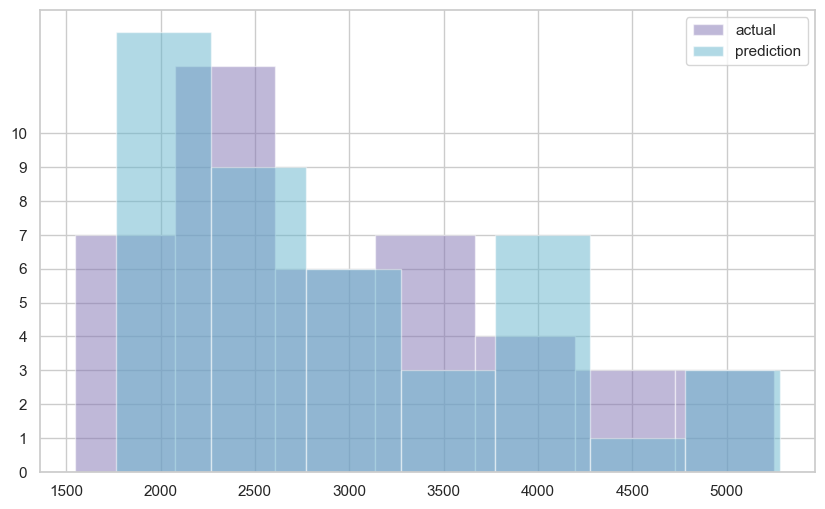

In [48]:
# Actual Vs Predicted graph

sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (10, 6) 
_, ax = plt.subplots()
ax.hist(data.Sales, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(pred_final, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,11))
ax.legend(loc = 'best')
plt.show()

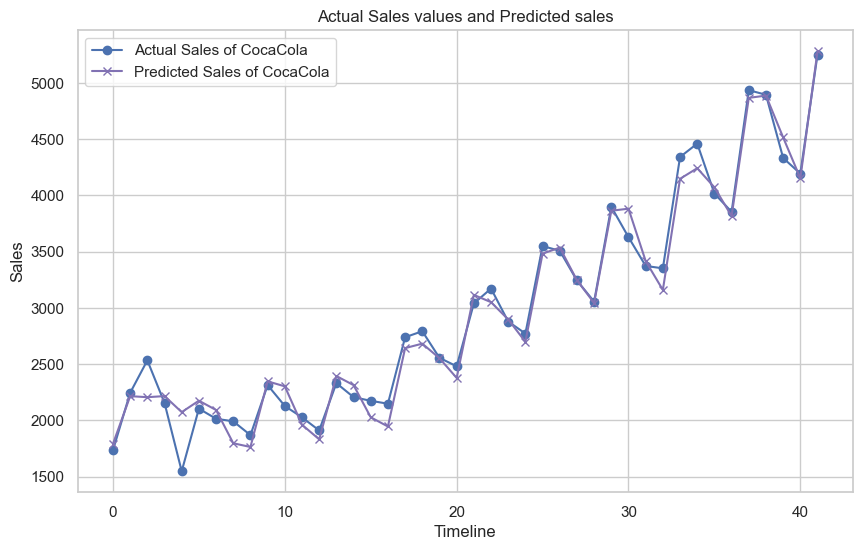

In [49]:
# Plot of Actual Sales values and Predicted sales values
plt.plot(data.Sales, color='b',marker='o', label='Actual Sales of CocaCola')
plt.plot(pred_final, color='m',marker='x', label='Predicted Sales of CocaCola')

# Added titles and adjust dimensions
plt.title('Actual Sales values and Predicted sales')
plt.xlabel("Timeline")
plt.ylabel("Sales")
plt.legend()
plt.rcParams['figure.figsize'] = (10,8) 

plt.show()